In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import GPT2Tokenizer
import seaborn as sns
from src.model import GPT

dataset = "openwebtext"
model = "gpt2"
dataset_suffix = "_gpt2.bin"
block_size = 512

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
special_vocab = [11, 13, 198, 262, 286, 284, 290, 257, 287]

[tokenizer.decode(t) for t in special_vocab]

/home/jiajun/Sharing/uncover-hidden-geometry/.uncover/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[',', '.', '\n', ' the', ' of', ' to', ' and', ' a', ' in']

In [2]:
root_dir = "out/decompositions/"
data_dir = os.path.join(root_dir, f"{dataset}-{model}")
suffix = "id1-512_none_train.npy"
global_mean = np.load(os.path.join(data_dir, f"global_mean_{suffix}"))
pos = np.load(os.path.join(data_dir, f"pos_{suffix}"))
cbasis = np.load(os.path.join(data_dir, f"cbasis_{suffix}"))
token = np.load(os.path.join(data_dir, f"token_{suffix}"))

In [3]:
pos.shape, cbasis.shape, token.shape

((13, 511, 768), (13, 6400, 768), (13, 10, 768))

### Gram of token embd

1. 标点符号和介词形成两个cluster，并且几乎垂直
2. layer之间的表现几乎不变，除了最后一层是例外
3. corr("the", "a")和corr(",", "and")比较突出
2. 存在 outlier 447

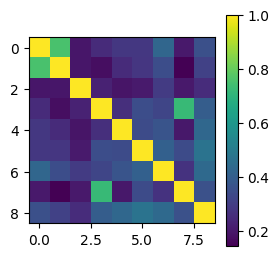

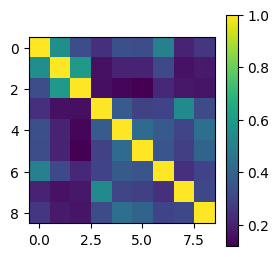

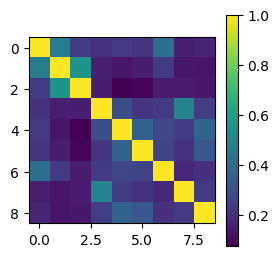

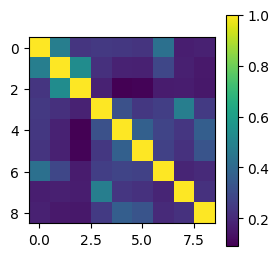

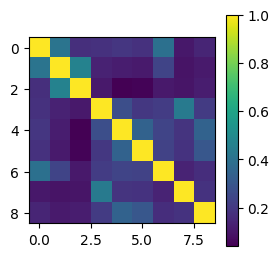

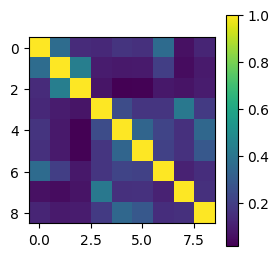

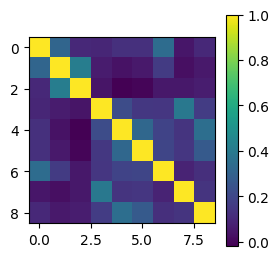

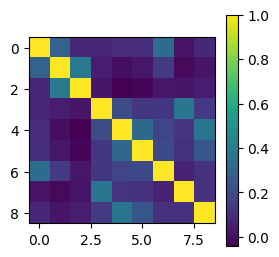

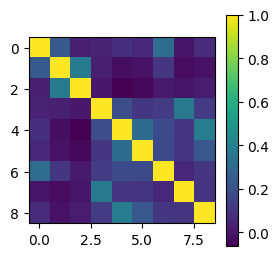

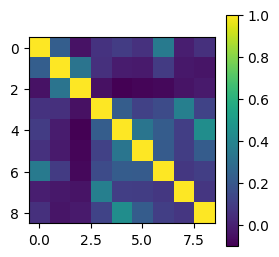

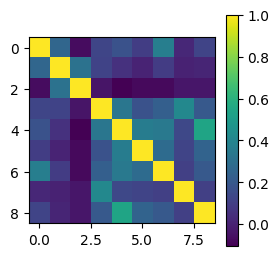

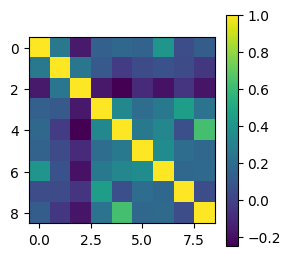

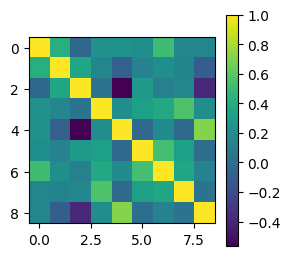

In [4]:
L = 13
for layer in range(L):
    t = token[layer, :-1]
    t = t / np.sqrt(np.sum(t**2, axis=1, keepdims=True))
    gram = t @ t.T
    plt.figure(figsize=(3, 3))
    plt.imshow(gram)
    plt.colorbar()
    plt.show()

### Gram of combined p + c + t

1. token basis, pos basis 近乎垂直
2. token basis, cbasis 也近乎垂直，但似乎噪声更多
3. layer之间的表现比较consistent，除了最后一层是例外

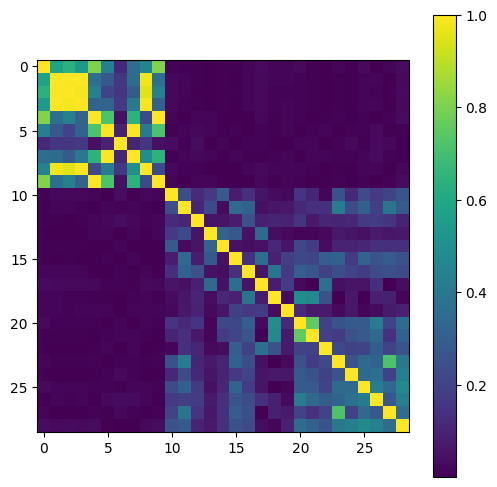

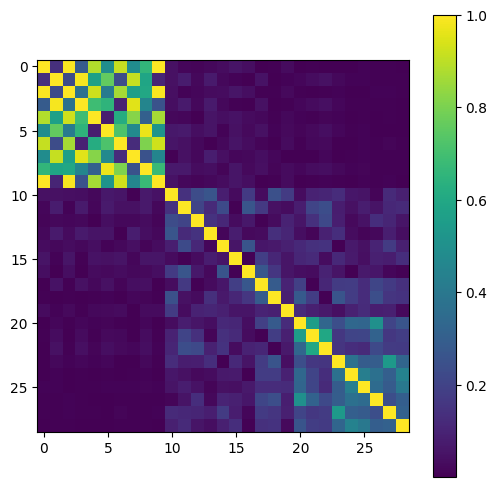

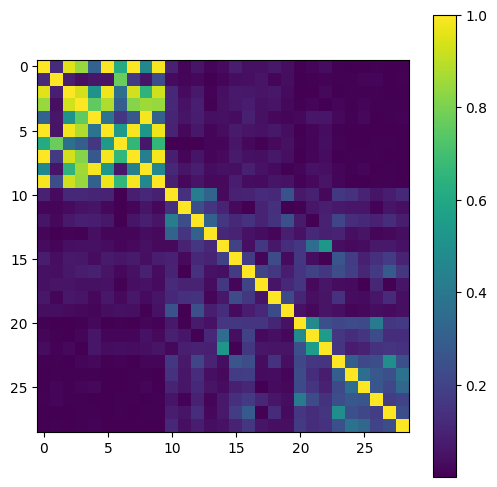

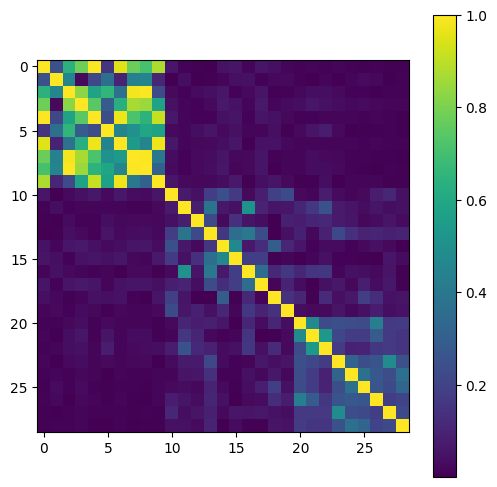

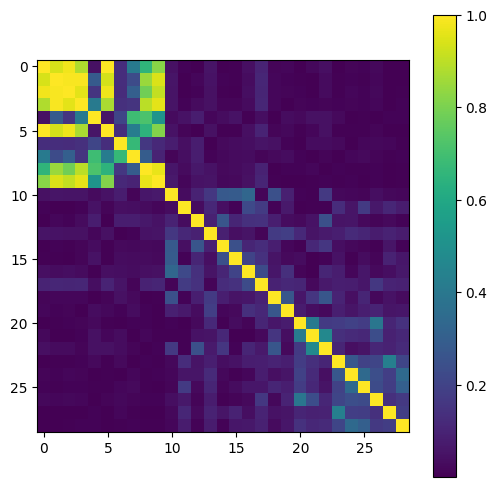

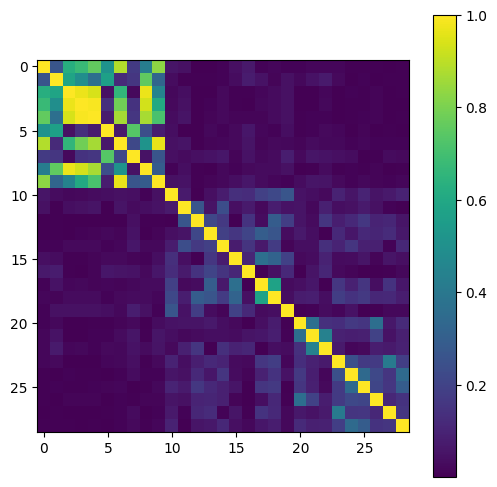

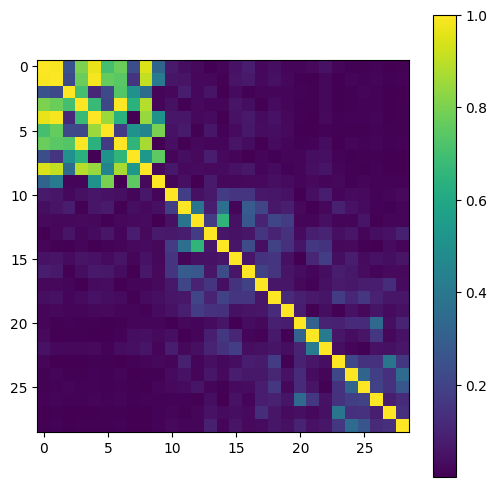

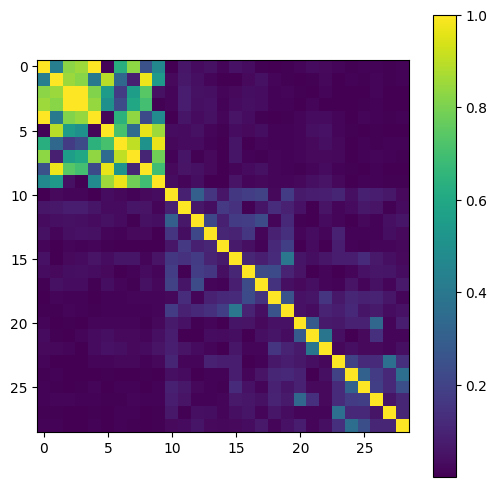

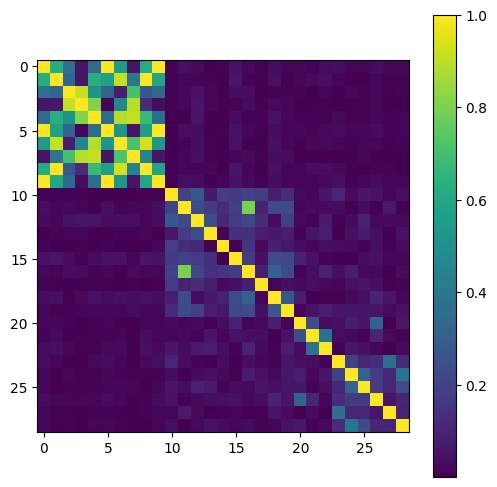

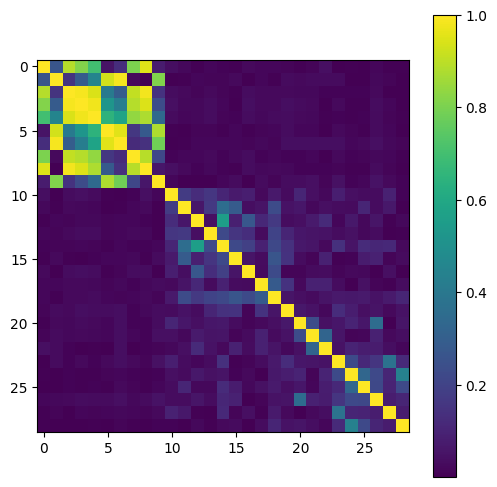

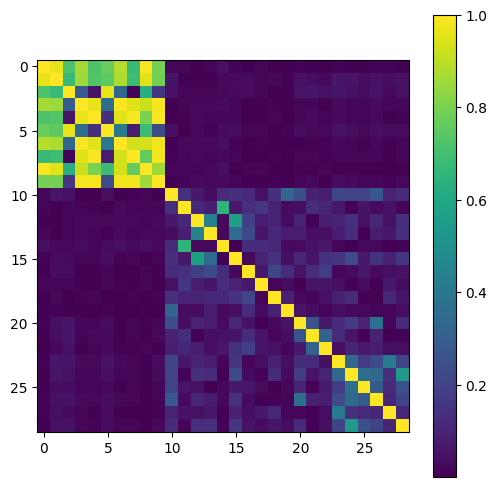

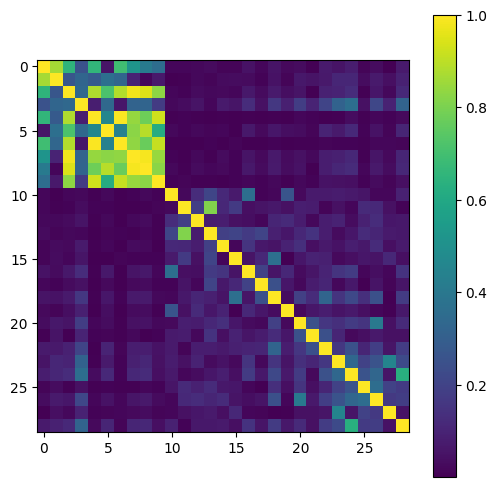

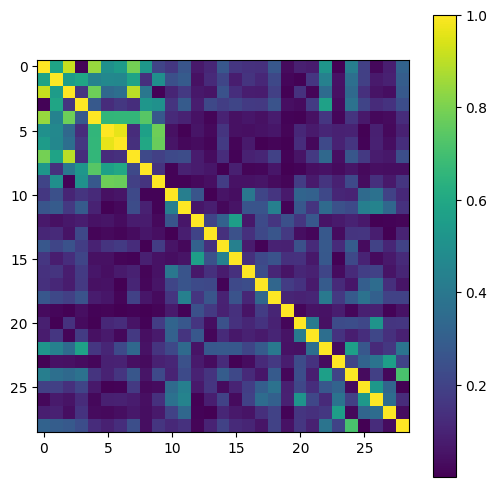

In [5]:
L = 13
for layer in range(L):
    p = pos[layer, np.random.randint(0, 511, 10)]
    c = cbasis[layer, np.random.randint(0, 6400, 10)]
    t = token[layer, :-1]

    combined = np.vstack([p, c, t])
    combined = combined / np.sqrt(np.sum(combined**2, axis=1, keepdims=True))
    gram = np.abs(combined @ combined.T)
    plt.figure(figsize=(6, 6))
    plt.imshow(gram)
    plt.colorbar()
    plt.show()

### Structure of rotated QK matrix

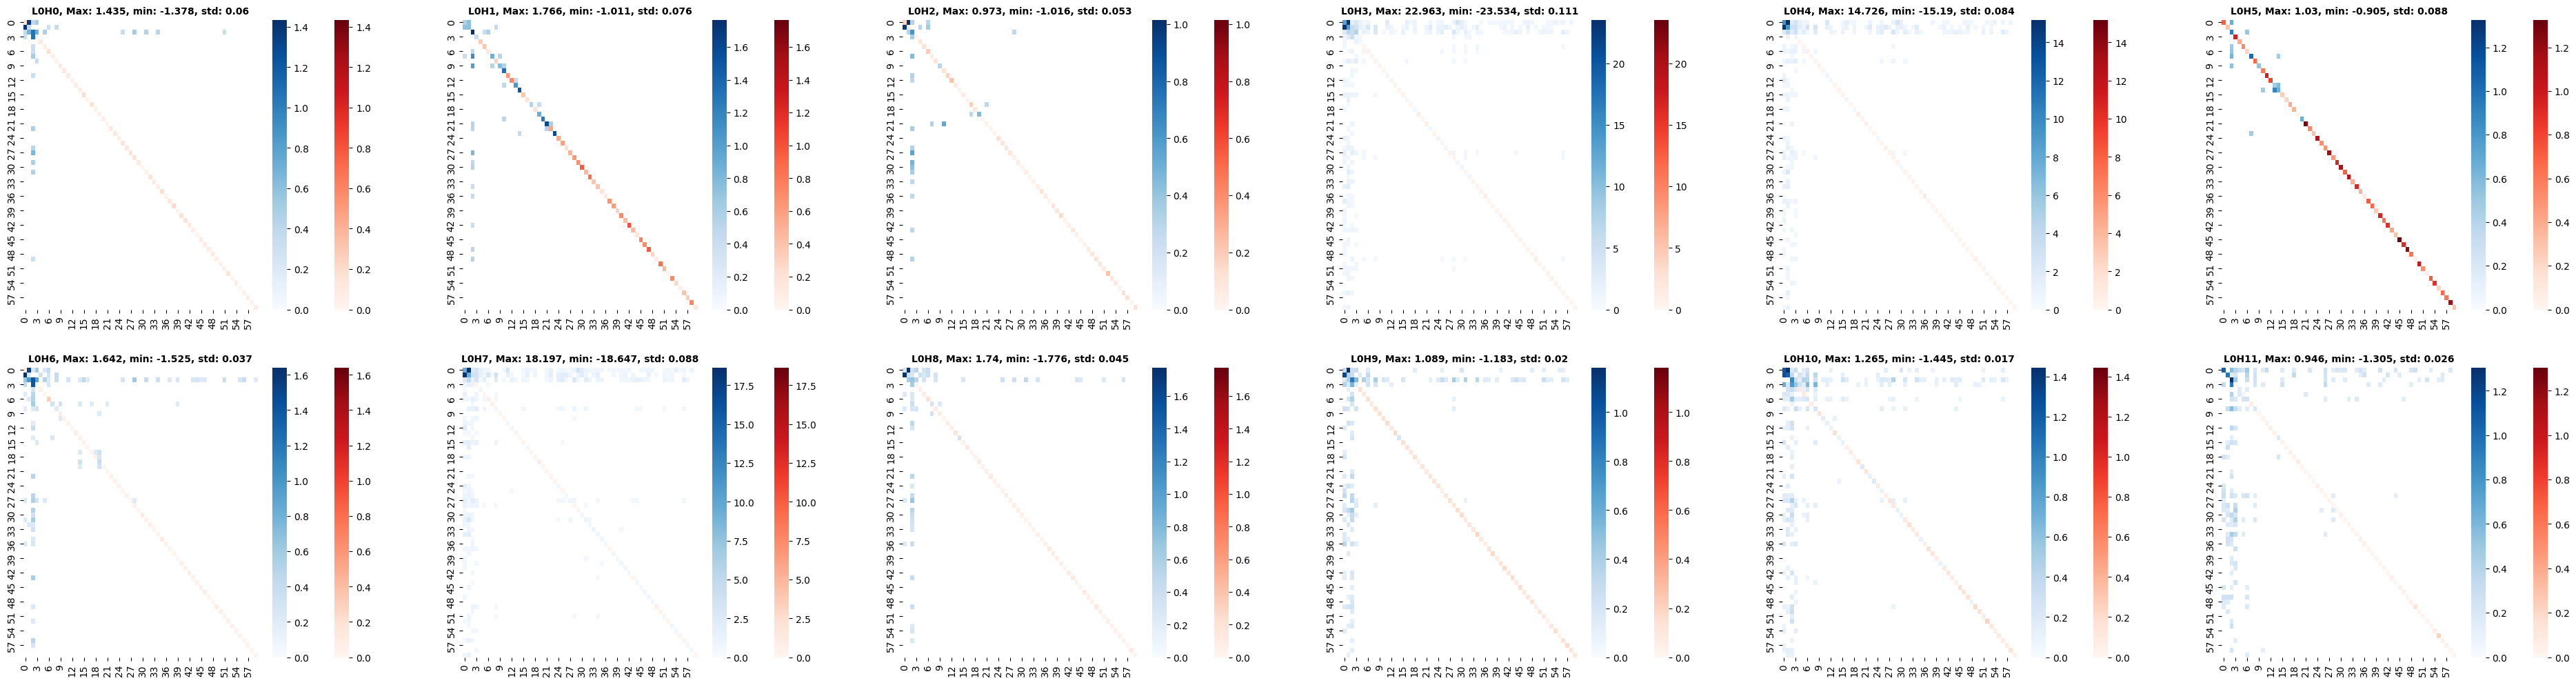

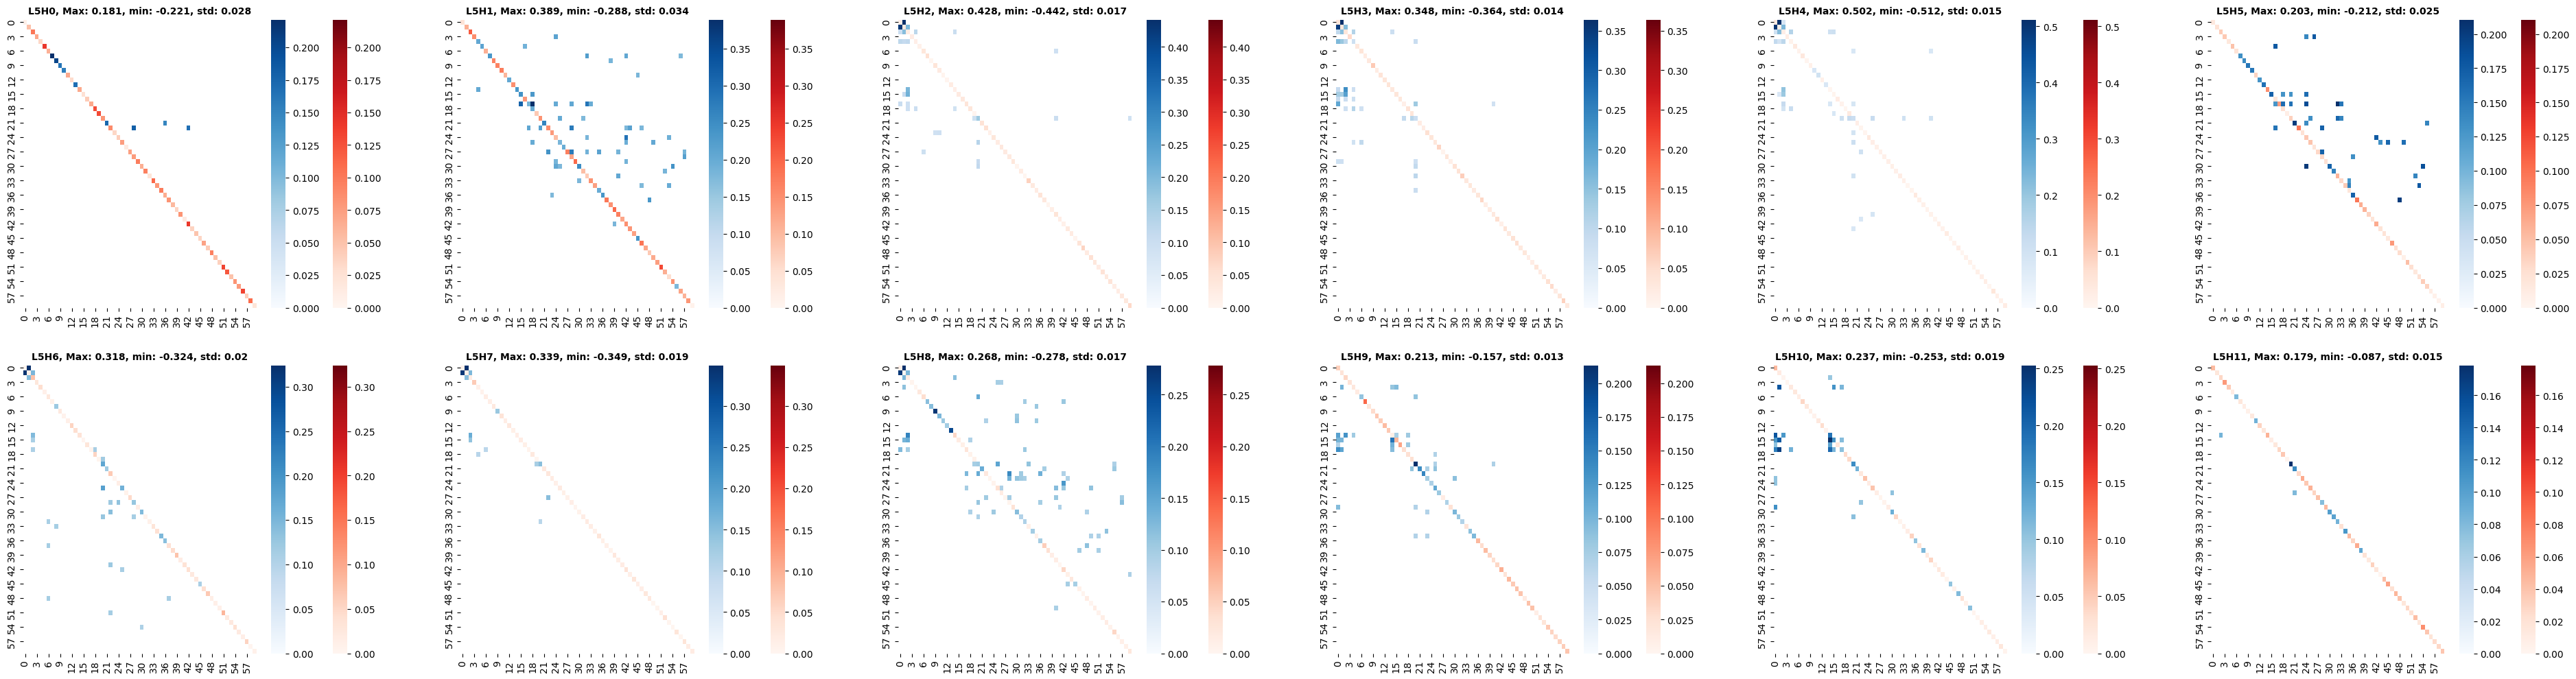

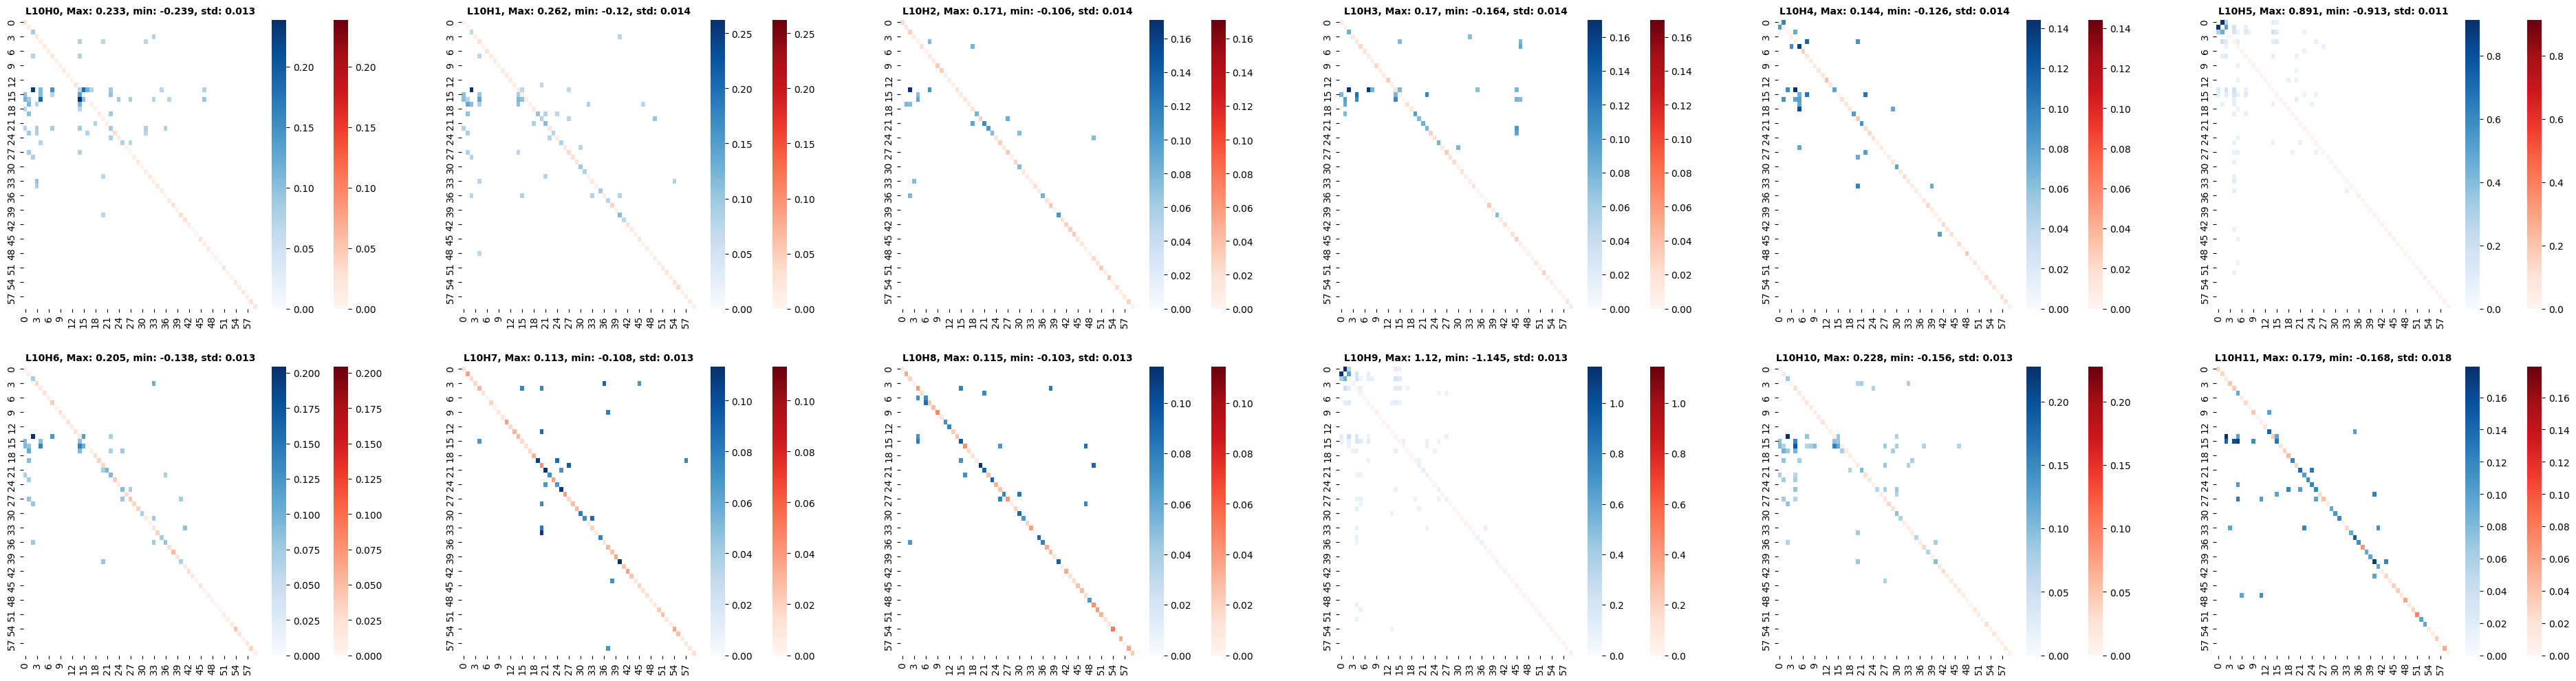

In [7]:
model = GPT.from_pretrained("gpt2")
L = model.config.n_layer
H = model.config.n_head
C = model.config.n_embd

sigma_multiplier = np.sqrt(2 * np.log(C**2))  # denoising parameter
top_num = 60  # how many top indices to show


def my_round(a, fac=1e3):
    return np.round(a * fac) / fac


def plot(layer_idx, pos, prep_token):
    block = model.transformer.h[layer_idx]
    W_q, W_k, _ = block.attn.c_attn.weight.split(C, dim=0)
    W_q = W_q.T.view(C, H, C // H)
    W_k = W_k.T.view(C, H, C // H)

    W_QK = np.zeros((H, C, C))
    stats = np.zeros((L, H, 3))

    p = pos[layer_idx]  # T, d
    t = prep_token[layer_idx]  # n_token, d
    combined = np.vstack([p, t])
    # u, s, vt_p = np.linalg.svd(p, full_matrices=False)
    # u, s, vt_t = np.linalg.svd(t, full_matrices=False)
    # vt = np.vstack([vt_p, vt_t])
    u, s, vt = np.linalg.svd(combined)

    nrow, ncol = 2, 6
    fig, axs = plt.subplots(nrow, ncol, figsize=(8 * ncol, 6 * nrow))
    for head in range(H):
        W_QK[head] = (W_q[:, head, :] @ W_k[:, head, :].T / np.sqrt(C // H)).numpy(
            force=True
        )
        W_QK_rot = vt @ (W_QK[head] - np.diag(np.diag(W_QK[head]))) @ vt.T
        stats[layer_idx, head, :] = np.array(
            [
                my_round(np.max(W_QK_rot.flatten())),
                my_round(np.min(W_QK_rot.flatten())),
                my_round(np.std(W_QK_rot.flatten())),
            ]
        )
        threshold = sigma_multiplier * stats[layer_idx, head, 2]
        indicator_sparse = np.abs(W_QK_rot) > threshold

        indicator_diagonal = np.eye(C, dtype=bool)
        W_QK_diagonal = W_QK[head] * indicator_diagonal
        W_QK_rot_sparse = W_QK_rot * indicator_sparse
        vmax1 = np.max(np.abs(W_QK_diagonal[:top_num, :top_num]))
        vmax2 = np.max(np.abs(W_QK_rot_sparse[:top_num, :top_num]))
        vmax = np.maximum(vmax1, vmax2)
        W_QK_diagonal[W_QK_diagonal == 0] = float("nan")
        W_QK_rot_sparse[W_QK_rot_sparse == 0] = float("nan")

        ax = axs[head // ncol, head % ncol]
        sns.heatmap(
            np.abs(W_QK_diagonal[:top_num, :top_num]),
            cmap="Reds",
            vmin=0,
            vmax=vmax,
            ax=ax,
        )
        sns.heatmap(
            np.abs(W_QK_rot_sparse[:top_num, :top_num]),
            cmap="Blues",
            vmin=0,
            vmax=vmax,
            ax=ax,
        )

        title = f"L{layer_idx}H{head}, "
        title += f"Max: {stats[layer_idx,head,0]}, min: {stats[layer_idx,head,1]}, std: {stats[layer_idx,head,2]}"
        ax.set_title(
            title,
            fontsize=10,
            weight="bold",
        )

    # plt.savefig(f"Figures/rotated-QK-{layer_idx}.png")
    plt.show()


for layer in [0, 5, 10]:
    plot(layer, pos, token)